In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [117]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
sys.path.append('../../')
import compute_preprocessing

In [3]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [4]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [5]:
import tensorflow as tf

In [6]:
import pugna.layers
import pugna.activations

In [7]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [8]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

def preload_phase(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/phase.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/phase_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [9]:
best_amp_model = '../quick_run_1/009/model.h5'
best_phase_model = '../phase_quick_run_1/008/model.h5'

In [14]:
amp_model = tf.keras.models.load_model(best_amp_model,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

In [15]:
phase_model = tf.keras.models.load_model(best_phase_model,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

In [17]:
amp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale (Mscale)              (None, 1024)              5120      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 2,105,345
Trainable params: 2,105,345
Non-trainable params: 0
_________________________________________________________________


In [18]:
phase_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_1 (Mscale)            (None, 1024)              5120      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1

In [19]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/upscale/"

In [21]:
times, times_scaled, coords, amp_ys_raw, amp_ys, amp_ys_processing_params = preload_amp(data_dir=data_dir)

In [20]:
_, _, _, phase_ys_raw, phase_ys, phase_ys_processing_params = preload_phase(data_dir=data_dir)

In [22]:
coords.shape

(3, 1000)

In [23]:
amp_ys.shape

(1000, 1099)

In [24]:
phase_ys.shape

(1000, 1099)

In [25]:
times

array([-499.50529851, -499.00529851, -498.50529851, ...,   48.49470149,
         48.99470149,   49.49470149])

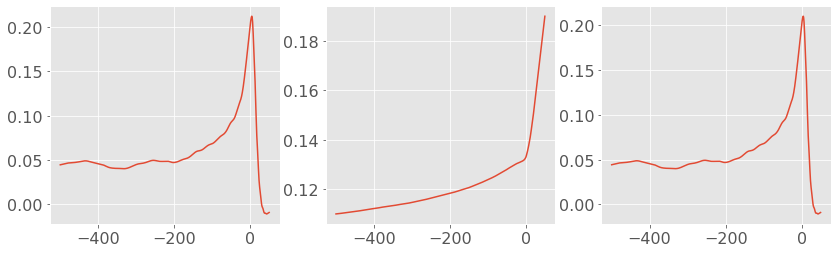

In [29]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(times, amp_ys[0])

plt.subplot(1, 3, 2)
plt.plot(times, phase_ys[0])

# this doesn't work because you need to scale the phase data back to normal or use the 'raw' data
plt.subplot(1, 3, 3)
_h = amp_ys[0]*np.exp(-1.j*phase_ys[0])
plt.plot(times, np.real(_h))

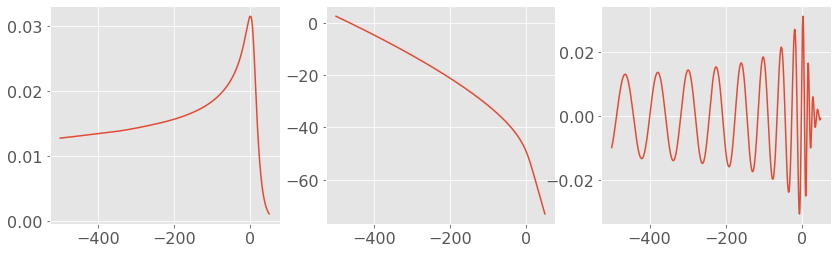

In [28]:
# using the 'raw' data
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(times, amp_ys_raw[0])

plt.subplot(1, 3, 2)
plt.plot(times, phase_ys_raw[0])

plt.subplot(1, 3, 3)
_h_raw = amp_ys_raw[0]*np.exp(-1.j*phase_ys_raw[0])
plt.plot(times, np.real(_h_raw))

In [153]:
def compare_models(index, amp_ys_raw, amp_preprocessing_params, phase_ys_raw, phase_preprocessing_params, coords, times_scaled, times, amp_model, phase_model, xlim=None):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    
    amp_hat = amp_model.predict(Xhat).T
    amp_hat = compute_preprocessing.apply_pre_process_reverse(amp_hat, amp_preprocessing_params['mean'], amp_preprocessing_params['max'])[0]
    
    phase_hat = phase_model.predict(Xhat).T
    phase_hat = compute_preprocessing.apply_pre_process_reverse(phase_hat, phase_preprocessing_params['mean'], phase_preprocessing_params['max'])[0]

    
    # not sure on sign of phase again!
    h_hat = amp_hat * np.exp(-1.j * phase_hat)
    
    h_raw = amp_ys_raw[index] * np.exp(-1.j * phase_ys_raw[index])
    
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 1, 1)
    plt.plot(times, np.real(h_raw), label='data')
    plt.plot(times, np.real(h_hat), label='model', ls='--')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if xlim:
        plt.xlim(*xlim)


    plt.subplot(4, 1, 2)
    plt.plot(times, np.abs(h_raw), label='data')
    plt.plot(times, np.abs(h_hat), label='model', ls='--')
    if xlim:
        plt.xlim(*xlim)

    plt.subplot(4, 1, 3)
    plt.plot(times, np.unwrap(np.angle(h_raw)), label='data')
    plt.plot(times, np.unwrap(np.angle(h_hat)), label='model', ls='--')
    if xlim:
        plt.xlim(*xlim)

        
    freq_ys_raw = IUS(times, np.unwrap(np.angle(h_raw))).derivative()(times)
    freq_hat = IUS(times, np.unwrap(np.angle(h_hat))).derivative()(times)


    plt.subplot(4, 1, 4)
    plt.plot(times, freq_ys_raw, label='data')
    plt.plot(times, freq_hat, label='model', ls='--')
    if xlim:
        plt.xlim(*xlim)

    

        
        
        
#     plt.figure(figsize=(14, 8))
#     plt.subplot(2, 1, 1)
#     plt.plot(times, ys_raw[index], label='data')
#     for k, v in yhats.items():
#         plt.plot(times, v, label=k, ls='--')
#     if xlim:
#         plt.xlim(*xlim)
# #     plt.xlim(-200, 50)
# #     plt.xlim(-10, 50)
# #     plt.yscale('log')
#     plt.title(title)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
#     plt.subplot(2, 1, 2)
#     for k, v in yhats.items():
# #         plt.plot(times, 100*np.abs((v-ys_raw[index])/ys_raw[index]), label=f"% (data-{k})")
#         plt.plot(times, (v-ys_raw[index]), label=f"% (data-{k})")
#     if xlim:
#         plt.xlim(*xlim)
#     if ylim:
#         plt.ylim(*ylim)
# #     plt.xlim(-200, 50)
# #     plt.xlim(-10, 50)
# #     plt.ylim(-10, 10)
# #     plt.yscale('log')
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [154]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3))

(array([ 73,  78, 754]),)

In [155]:
np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

(array([ 25,  46,  63,  65,  98, 102, 104, 119, 123, 124, 175, 192, 193,
        194, 210, 222, 229, 233, 252, 266, 275, 304, 320, 360, 395, 411,
        422, 433, 449, 460, 476, 488, 493, 502, 538, 542, 545, 566, 568,
        570, 646, 659, 661, 684, 685, 745, 754, 767, 771, 788, 810, 836,
        840, 852, 891, 948, 970]),)

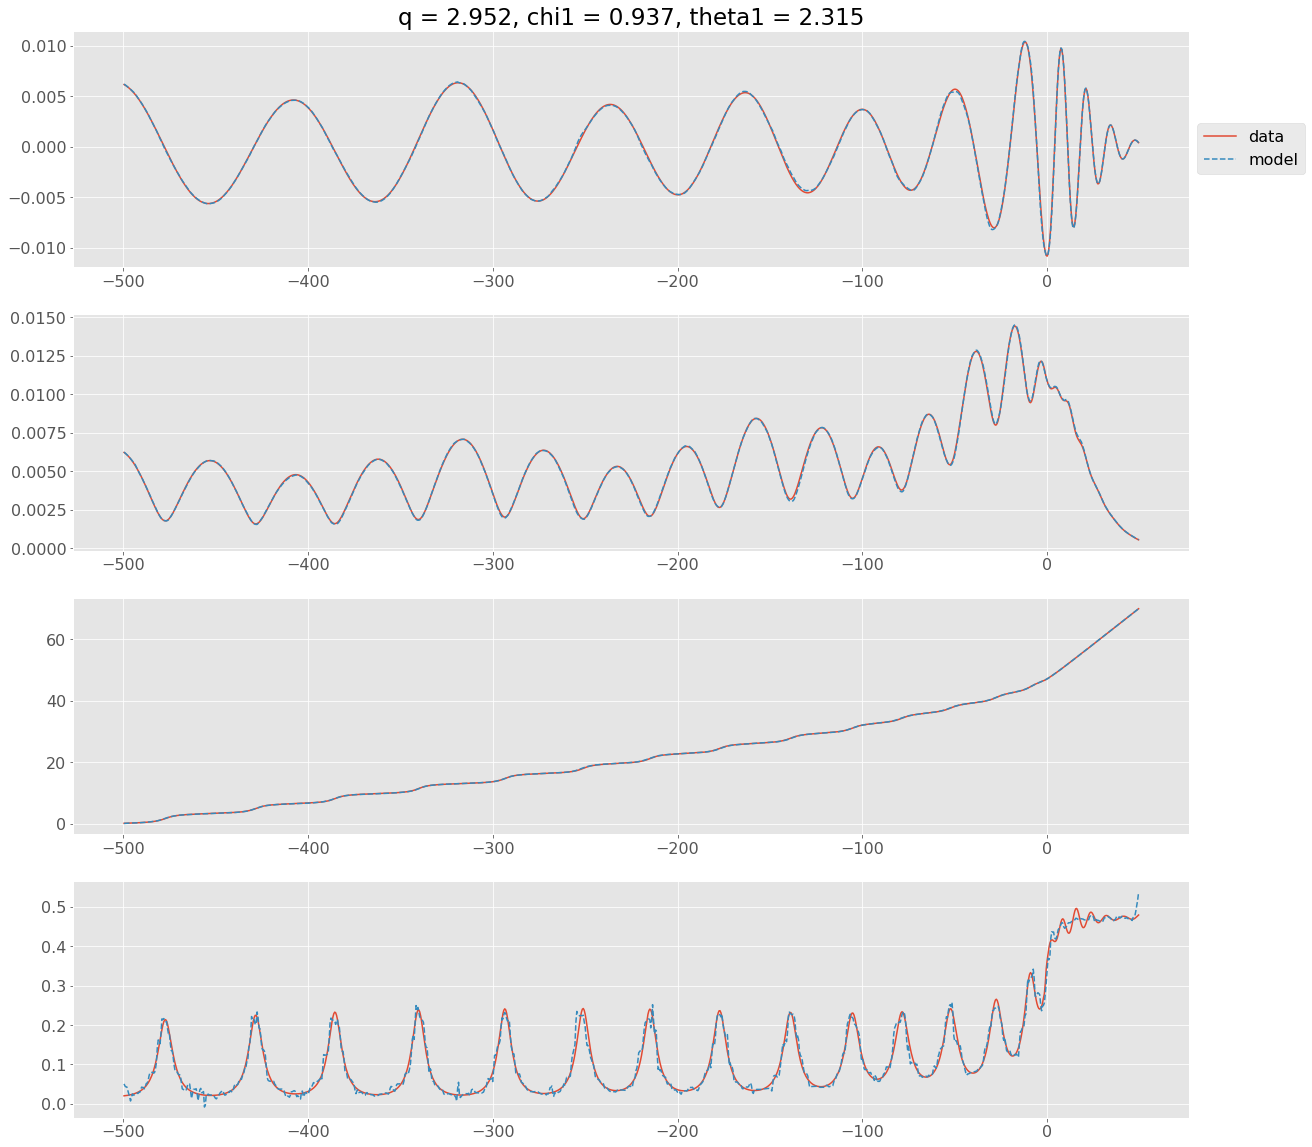

In [156]:
compare_models(index=191,
               amp_ys_raw=amp_ys_raw, amp_preprocessing_params=amp_ys_processing_params,
               phase_ys_raw=phase_ys_raw, phase_preprocessing_params=phase_ys_processing_params,
               coords=coords,
               times_scaled=times_scaled,
               times=times,
               amp_model=amp_model,
               phase_model=phase_model,
               xlim=None)

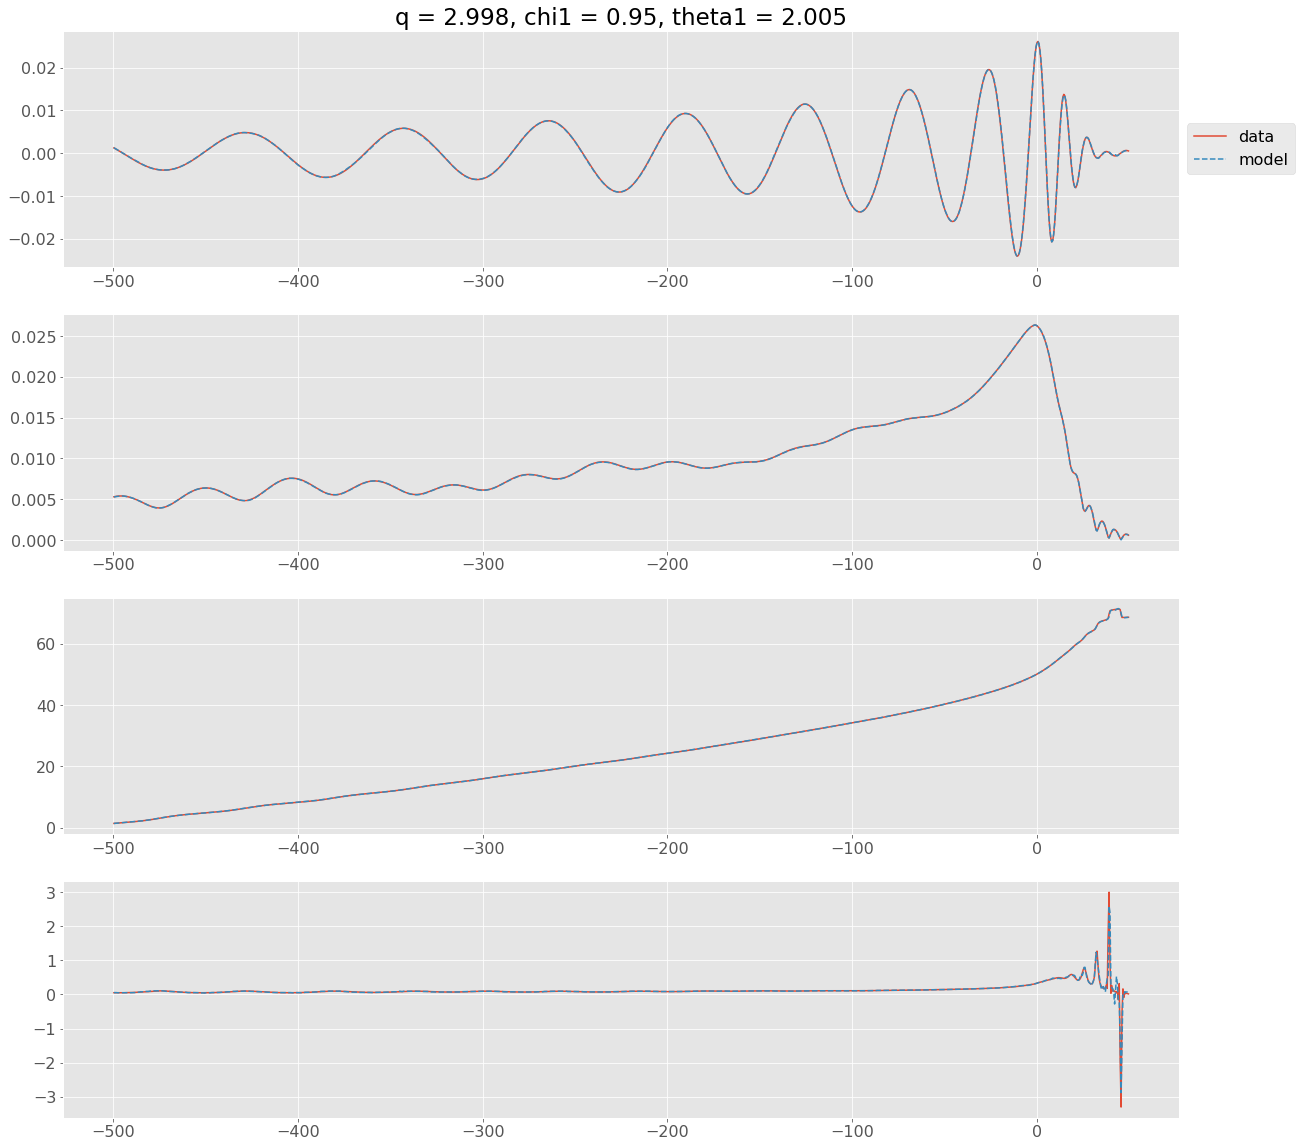

In [141]:
compare_models(index=789,
               amp_ys_raw=amp_ys_raw, amp_preprocessing_params=amp_ys_processing_params,
               phase_ys_raw=phase_ys_raw, phase_preprocessing_params=phase_ys_processing_params,
               coords=coords,
               times_scaled=times_scaled,
               times=times,
               amp_model=amp_model,
               phase_model=phase_model,
               xlim=None)

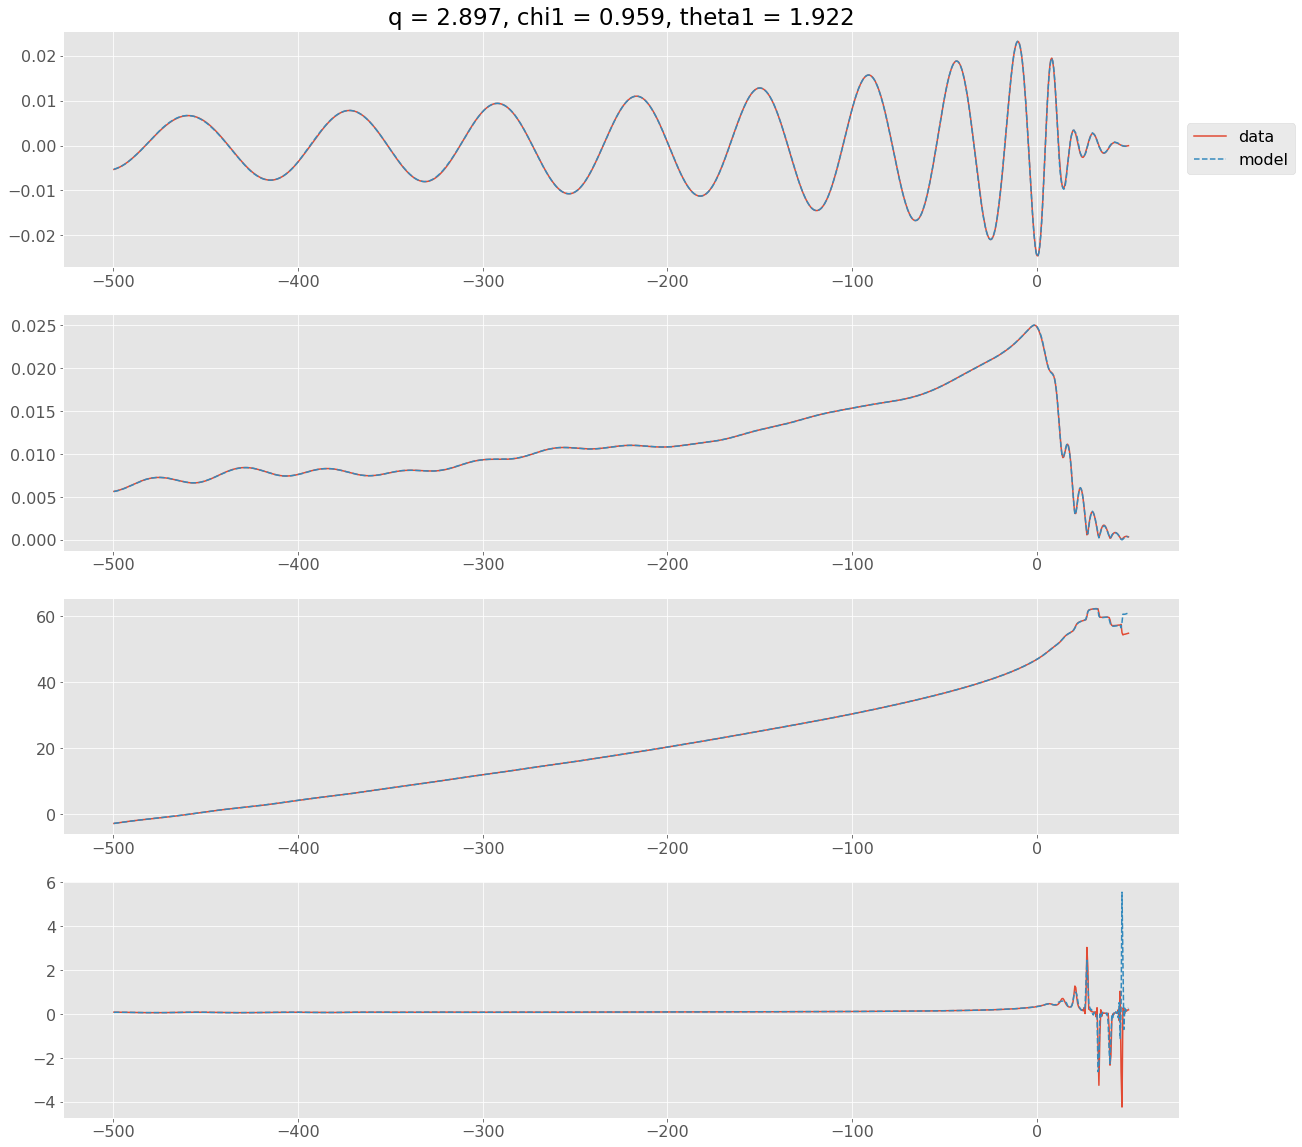

In [142]:
compare_models(index=361,
               amp_ys_raw=amp_ys_raw, amp_preprocessing_params=amp_ys_processing_params,
               phase_ys_raw=phase_ys_raw, phase_preprocessing_params=phase_ys_processing_params,
               coords=coords,
               times_scaled=times_scaled,
               times=times,
               amp_model=amp_model,
               phase_model=phase_model,
               xlim=None)

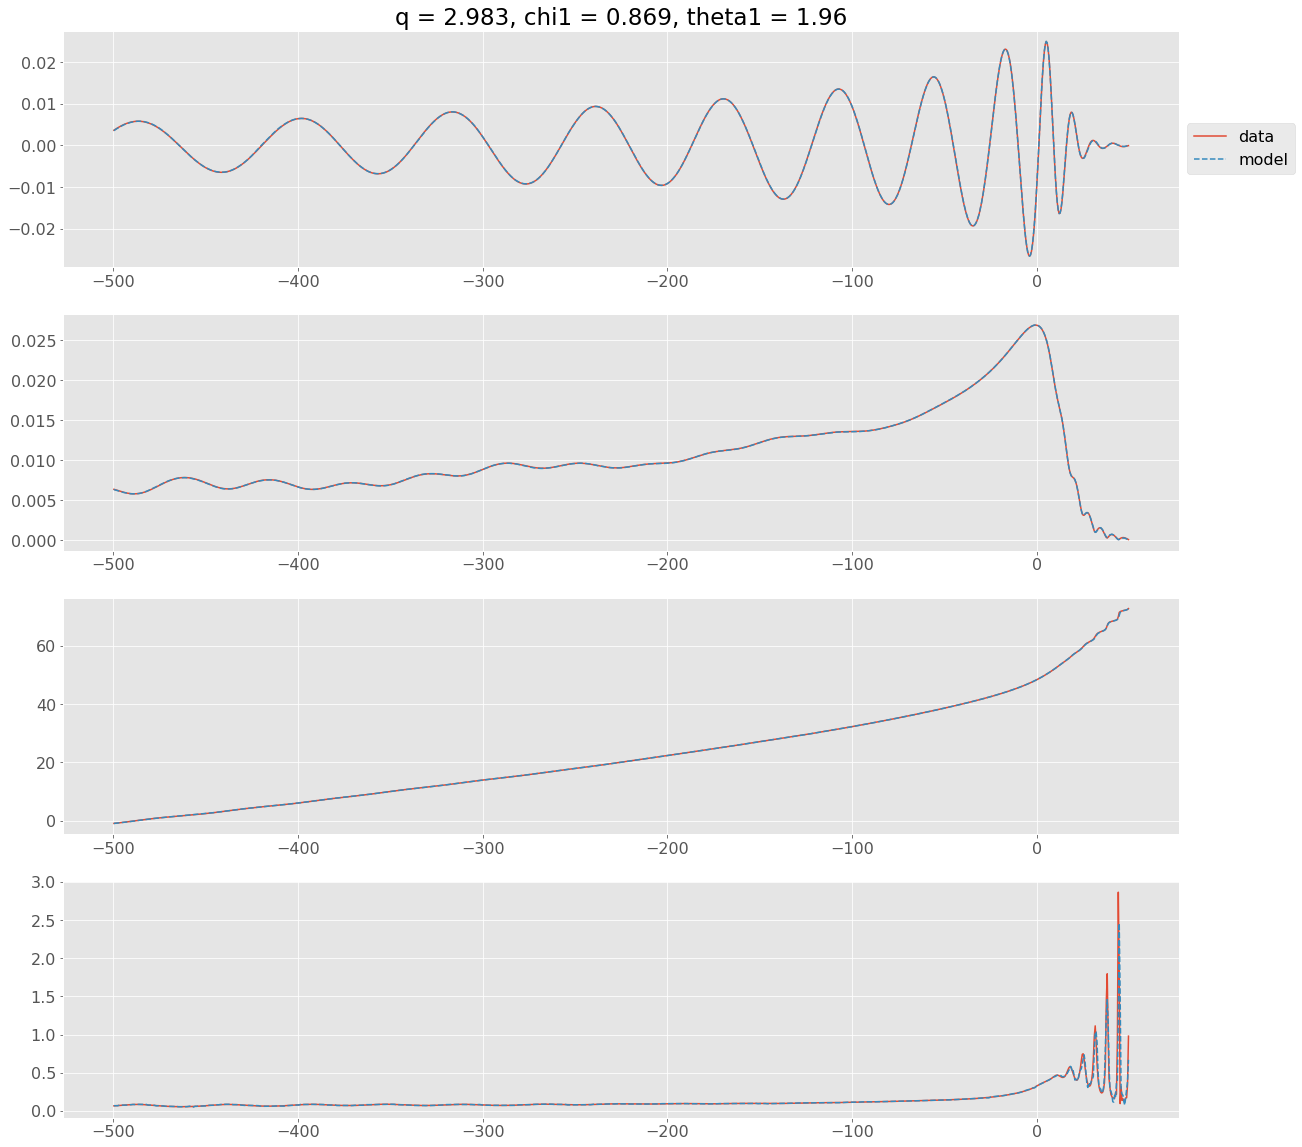

In [143]:
compare_models(index=82,
               amp_ys_raw=amp_ys_raw, amp_preprocessing_params=amp_ys_processing_params,
               phase_ys_raw=phase_ys_raw, phase_preprocessing_params=phase_ys_processing_params,
               coords=coords,
               times_scaled=times_scaled,
               times=times,
               amp_model=amp_model,
               phase_model=phase_model,
               xlim=None)

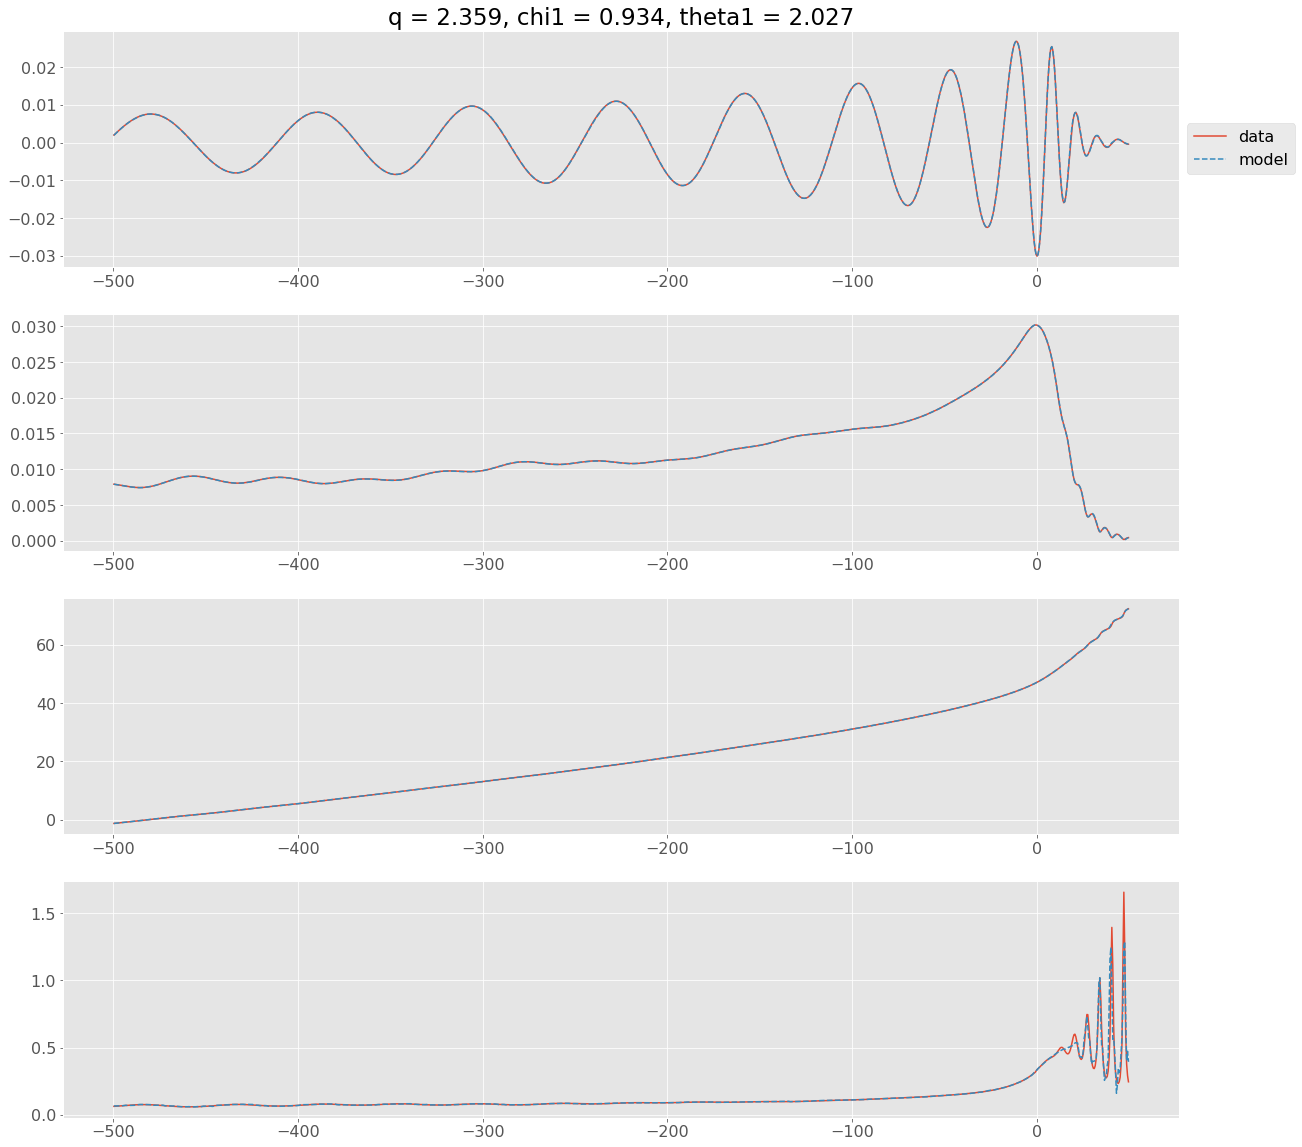

In [144]:
compare_models(index=699,
               amp_ys_raw=amp_ys_raw, amp_preprocessing_params=amp_ys_processing_params,
               phase_ys_raw=phase_ys_raw, phase_preprocessing_params=phase_ys_processing_params,
               coords=coords,
               times_scaled=times_scaled,
               times=times,
               amp_model=amp_model,
               phase_model=phase_model,
               xlim=None)